In [1]:
# install library yang dibutuhkan
!pip install imbalanced-learn
!pip install xgboost

# bila anda membuka program ini tanpa menggunakan google colab :
# bila terjadi error untuk menginstal imbalanced-learn, buka anaconda prompt anda lalu ketikkan : conda install -c conda-forge imbalanced-learn
# bila terjadi error untuk menginstal xgboost, buka anaconda prompt anda lalu ketikkan : pip install xgboost
# kemudian jalankan cell ini

In [2]:
# masukkan library yang dibutuhkan
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
# import data 

train = pd.read_csv('train.csv')

In [4]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


## Exploratory Data Analysis (EDA)

In [5]:
# mengetahui tipe data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [6]:
# mengecek apakah terdapat nilai null pada dataframe

train.isna().any()

state                            False
account_length                   False
area_code                        False
international_plan               False
voice_mail_plan                  False
number_vmail_messages            False
total_day_minutes                False
total_day_calls                  False
total_day_charge                 False
total_eve_minutes                False
total_eve_calls                  False
total_eve_charge                 False
total_night_minutes              False
total_night_calls                False
total_night_charge               False
total_intl_minutes               False
total_intl_calls                 False
total_intl_charge                False
number_customer_service_calls    False
churn                            False
dtype: bool

Dari tabel diatas diketahui bahwa tidak terdapat nilai null

In [7]:
# mengecek apakah terdapat data duplikat
train.duplicated().any()

False

In [8]:
train.describe().transpose()[['mean', '50%', 'min', 'max']]

,mean,50%,min,max
account_length,100.236235,100.00,1.0,243.00
number_vmail_messages,7.631765,0.00,0.0,52.00
total_day_minutes,180.259600,180.45,0.0,351.50
total_day_calls,99.907294,100.00,0.0,165.00
total_day_charge,30.644682,30.68,0.0,59.76
total_eve_minutes,200.173906,200.70,0.0,359.30
total_eve_calls,100.176471,100.00,0.0,170.00
total_eve_charge,17.015012,17.06,0.0,30.54
total_night_minutes,200.527882,200.45,0.0,395.00
total_night_calls,99.839529,100.00,0.0,175.00


- ketika mean > median, maka kolom berdistribusi positif
- ketika mean < median, maka kolom berdistribusi negatif
- Tidak terdapat nilai yang aneh (seperti total panggilan yang minus)

In [9]:
# mencari nilai modus
a2 = train.select_dtypes(['int64', 'float64']).columns

for i in a2:
   print(i, (train[i].mode()[0]))

account_length 90
number_vmail_messages 0
total_day_minutes 189.3
total_day_calls 105
total_day_charge 32.18
total_eve_minutes 230.9
total_eve_calls 105
total_eve_charge 14.25
total_night_minutes 186.2
total_night_calls 105
total_night_charge 9.4
total_intl_minutes 11.1
total_intl_calls 3
total_intl_charge 3.0
number_customer_service_calls 1


In [10]:
# untuk melihat deskripsi dari data bertipe object
train.select_dtypes('object').describe() 

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


In [11]:
train_grp = train.groupby('churn').agg({'state' : 'count'}).reset_index()

Text(0, 0.5, 'Jumlah Data')

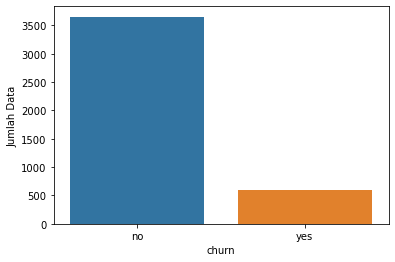

In [12]:
sns.barplot(x='churn', y='state', data= train_grp)
plt.ylabel('Jumlah Data')

In [13]:
train['churn'].value_counts()

no     3652
yes     598
Name: churn, dtype: int64

Diketahui bahwa jumlah churn dan tidak churn berbeda cukup jauh, sehingga kita perlu melakukan oversampling atau undersampling untuk mengurangi resiko overfitting.

In [14]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [15]:
train_grp2 = train.groupby(['churn', 'area_code']).agg({'account_length' : 'count'}).reset_index()

Text(0, 0.5, 'Jumlah Data')

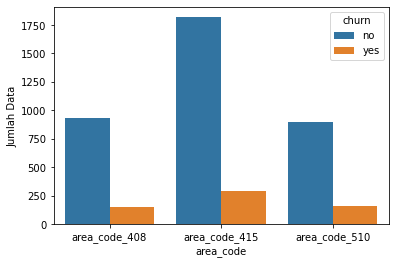

In [16]:
sns.barplot(x='area_code', y='account_length', data= train_grp2, hue='churn')
plt.ylabel('Jumlah Data')

Text(0, 0.5, 'Jumlah Data')

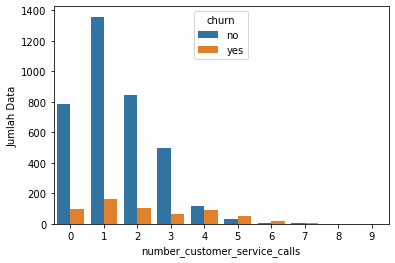

In [17]:
train_grp3 = train.groupby(['churn', 'number_customer_service_calls']).agg({'account_length' : 'count'}).reset_index()

sns.barplot(x='number_customer_service_calls', y='account_length', data= train_grp3, hue='churn')
plt.ylabel('Jumlah Data')

## Data Preprocessing 

In [18]:
# merubah tipe data pada kolom kategorikal menjadi numeric
# yaitu kolom churn, voice_mail_plan, international_plan
def rubah(x):
    if x == 'yes':
        hasil = 1
    else:
        hasil = 0
    return hasil

In [19]:
train['churn'] = train['churn'].apply(lambda x:rubah(x))
train['voice_mail_plan'] = train['voice_mail_plan'].apply(lambda x:rubah(x))
train['international_plan'] = train['international_plan'].apply(lambda x:rubah(x))

In [20]:
def get_nonself_correlation(df,self_name):
    temp = df.select_dtypes(exclude=object).corr().abs()
    temp = temp.loc[temp.index!=self_name,temp.columns==self_name]
    temp = temp.unstack().reset_index()
    temp.columns = ['corr_matrix', 'dfbase', 'correlation'] 
    return temp

In [21]:
a = get_nonself_correlation(train, 'churn').sort_values(by='correlation', ascending = False).reset_index()

In [22]:
a

,index,corr_matrix,dfbase,correlation
0,1,churn,international_plan,0.259053
1,16,churn,number_customer_service_calls,0.221220
2,4,churn,total_day_minutes,0.215272
3,6,churn,total_day_charge,0.215263
4,2,churn,voice_mail_plan,0.114643
5,3,churn,number_vmail_messages,0.100347
6,7,churn,total_eve_minutes,0.078855
7,9,churn,total_eve_charge,0.078852
8,13,churn,total_intl_minutes,0.055186
9,15,churn,total_intl_charge,0.055177


Terlihat bahwa korelasi kolom churn dengan kolom lainnya cukup rendah, oleh sebab itu kita akan mengambil kolom dengan nilai korelasi diatas > 0.1 dengan churn

In [23]:
b = a[a['correlation'] > 0.1]['dfbase']

In [24]:
kolom = []
for i in range(0,len(b)):
    kolom.append(b[i])

In [25]:
kolom

['international_plan',
 'number_customer_service_calls',
 'total_day_minutes',
 'total_day_charge',
 'voice_mail_plan',
 'number_vmail_messages']

In [26]:
train_numeric = train[kolom]
train_numeric.head()

,international_plan,number_customer_service_calls,total_day_minutes,total_day_charge,voice_mail_plan,number_vmail_messages
0,0,1,161.6,27.47,1,26
1,0,0,243.4,41.38,0,0
2,1,2,299.4,50.90,0,0
3,1,3,166.7,28.34,0,0
4,0,3,218.2,37.09,1,24


In [27]:
train_object = train.select_dtypes('object')

In [28]:
train_object

,state,area_code
0,OH,area_code_415
1,NJ,area_code_415
2,OH,area_code_408
3,OK,area_code_415
4,MA,area_code_510
...,...,...
4245,MT,area_code_415
4246,WV,area_code_408
4247,NC,area_code_408
4248,HI,area_code_408


In [29]:
train_deteksi = train['churn']

In [30]:
train_upd = pd.concat([train_object, train_numeric, train_deteksi],axis=1)

In [31]:
train_upd

,state,area_code,international_plan,number_customer_service_calls,total_day_minutes,total_day_charge,voice_mail_plan,number_vmail_messages,churn
0,OH,area_code_415,0,1,161.6,27.47,1,26,0
1,NJ,area_code_415,0,0,243.4,41.38,0,0,0
2,OH,area_code_408,1,2,299.4,50.90,0,0,0
3,OK,area_code_415,1,3,166.7,28.34,0,0,0
4,MA,area_code_510,0,3,218.2,37.09,1,24,0
...,...,...,...,...,...,...,...,...,...
4245,MT,area_code_415,0,0,188.3,32.01,0,0,0
4246,WV,area_code_408,0,3,177.9,30.24,0,0,0
4247,NC,area_code_408,0,1,170.7,29.02,0,0,0
4248,HI,area_code_408,0,2,235.7,40.07,1,40,0


In [32]:
kolom_untuktest = pd.concat([train_object, train_numeric]).columns 
kolom_untuktest

Index(['state', 'area_code', 'international_plan',
       'number_customer_service_calls', 'total_day_minutes',
       'total_day_charge', 'voice_mail_plan', 'number_vmail_messages'],
      dtype='object')

# Membuat model

## Data Preprocessing

In [33]:
train_upd.columns

Index(['state', 'area_code', 'international_plan',
       'number_customer_service_calls', 'total_day_minutes',
       'total_day_charge', 'voice_mail_plan', 'number_vmail_messages',
       'churn'],
      dtype='object')

In [34]:
x = train_upd.drop(columns = 'churn')
y = train_upd['churn']

In [35]:
num_features = x.select_dtypes(exclude="object")
cat_features = x.select_dtypes(include="object")

cat_features2 = num_features[['international_plan','voice_mail_plan']]
num_features.drop(columns=['international_plan','voice_mail_plan'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
# Normalisasi fitur numerik
num_features_mean = num_features.mean()
num_features_std = num_features.std()

num_features = (num_features - num_features_mean) / num_features_std
num_features.head()

,number_customer_service_calls,total_day_minutes,total_day_charge,number_vmail_messages
0,-0.426296,-0.345469,-0.345747,1.366696
1,-1.188820,1.168999,1.169158,-0.567845
2,0.336228,2.205798,2.205958,-0.567845
3,1.098753,-0.251046,-0.250997,-0.567845
4,1.098753,0.702439,0.701944,1.217885


In [37]:
# OneHotEncode fitur kategorik
cat_features = pd.get_dummies(cat_features)
cat_features

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
# Gabungkan Fitur
features_full = pd.concat([num_features, cat_features,cat_features2], axis=1)
x = features_full
x

,number_customer_service_calls,total_day_minutes,total_day_charge,number_vmail_messages,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,...,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan,voice_mail_plan
0,-0.426296,-0.345469,-0.345747,1.366696,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,-1.188820,1.168999,1.169158,-0.567845,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.336228,2.205798,2.205958,-0.567845,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.098753,-0.251046,-0.250997,-0.567845,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1.098753,0.702439,0.701944,1.217885,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,-1.188820,0.148862,0.148693,-0.567845,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4246,1.098753,-0.043686,-0.044073,-0.567845,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4247,-0.426296,-0.176989,-0.176940,-0.567845,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4248,0.336228,1.026439,1.026489,2.408372,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [39]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

## Sampling

In [40]:
y.value_counts()

0    3652
1     598
Name: churn, dtype: int64

Kita akan mencoba melakukan dua macam sampling, yaitu oversampling dan undersampling

### Over Sampling

In [41]:
sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x, y.ravel())

In [42]:
print("Before OverSampling, counts of label '1': {}".format(sum(y == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))

print("After OverSampling, counts of label '1': {}".format(sum(y_over == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_over == 0)))

Before OverSampling, counts of label '1': 598
Before OverSampling, counts of label '0': 3652 

After OverSampling, counts of label '1': 3652
After OverSampling, counts of label '0': 3652


In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size = 0.2, random_state=1)

### Under Sampling

In [44]:
rus = RandomUnderSampler(random_state=42)
x_under, y_under = rus.fit_resample(x, y.ravel())

In [45]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y == 0)))

print("After UnderSampling, counts of label '1': {}".format(sum(y_under == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_under == 0)))

Before UnderSampling, counts of label '1': 598
Before UnderSampling, counts of label '0': 3652 

After UnderSampling, counts of label '1': 598
After UnderSampling, counts of label '0': 598


In [46]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size = 0.2, random_state=1)

## Membuat Model

In [47]:
def confusionmatrix(predictions):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

### Logistic regression Menggunakan over Sampling

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       740
           1       0.91      0.88      0.89       721

    accuracy                           0.90      1461
   macro avg       0.90      0.90      0.90      1461
weighted avg       0.90      0.90      0.90      1461



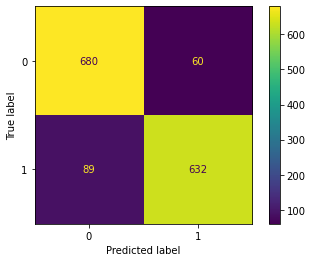

In [48]:
lr1 = LogisticRegression(max_iter = 10000)
lr1.fit(x_train, y_train.ravel())
predictions = lr1.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions)

### Logistic regression Menggunakan Under Sampling

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       740
           1       0.74      0.74      0.74       721

    accuracy                           0.74      1461
   macro avg       0.74      0.74      0.74      1461
weighted avg       0.74      0.74      0.74      1461



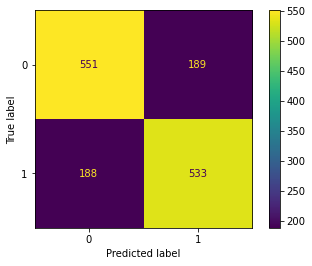

In [49]:
lr2 = LogisticRegression()
lr2.fit(x_train2, y_train2.ravel())
predictions = lr2.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions)

### XGBoost Menggunakan over Sampling

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       740
           1       0.92      0.91      0.92       721

    accuracy                           0.92      1461
   macro avg       0.92      0.92      0.92      1461
weighted avg       0.92      0.92      0.92      1461



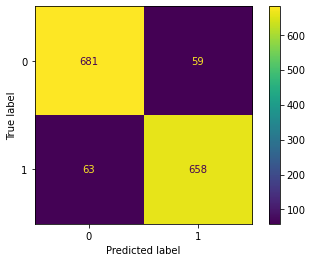

In [50]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train.ravel())

predictions = xgb_model.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions)

###  XGBoost Menggunakan under Sampling

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       740
           1       0.85      0.83      0.84       721

    accuracy                           0.84      1461
   macro avg       0.84      0.84      0.84      1461
weighted avg       0.84      0.84      0.84      1461



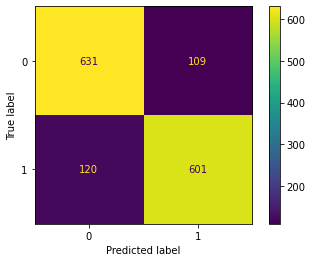

In [51]:
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model2.fit(x_under, y_under.ravel())

predictions = xgb_model2.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))

confusionmatrix(predictions)

Dari keempat model yang dilatih, didapatkan data bahwa XGBoost dengan data di over sampling memiliki akurasi terbaik

In [52]:
test = pd.read_csv('test.csv')

In [53]:
test2 = test[kolom_untuktest]

In [54]:
test2['voice_mail_plan'] = test2['voice_mail_plan'].apply(lambda x:rubah(x))
test2['international_plan'] = test2['international_plan'].apply(lambda x:rubah(x))

C:\Users\RAFFEL~1\AppData\Local\Temp/ipykernel_3232/3302558417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['voice_mail_plan'] = test2['voice_mail_plan'].apply(lambda x:rubah(x))
C:\Users\RAFFEL~1\AppData\Local\Temp/ipykernel_3232/3302558417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['international_plan'] = test2['international_plan'].apply(lambda x:rubah(x))


In [55]:
num_features = test2.select_dtypes(exclude="object")
cat_features = test2.select_dtypes(include="object")

cat_features2 = num_features[['international_plan','voice_mail_plan']]
num_features.drop(columns=['international_plan','voice_mail_plan'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [56]:
num_features = (num_features - num_features_mean) / num_features_std
cat_features = pd.get_dummies(cat_features)

In [57]:
test_after = pd.concat([num_features, cat_features,cat_features2], axis=1)

In [58]:
predictions = xgb_model.predict(test_after)

In [59]:
data = pd.DataFrame({'churn' : predictions})

In [60]:
test.reset_index(level = 0, inplace=True)
data.reset_index(level = 0,inplace=True)
test_final = test.merge(data, on='index')

In [61]:
test_final.drop('index', axis=1, inplace=True)

In [62]:
test_final.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,...,76,26.11,203.0,99,9.14,13.1,6,3.54,4,1
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,...,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,...,112,23.55,250.7,115,11.28,15.5,5,4.19,3,0


In [63]:
test_final['churn'].value_counts()

0    626
1    124
Name: churn, dtype: int64